In [0]:
!gdown  https://drive.google.com/uc?id=1595Dj3T2CtMlx_iuDJI9gLGc8-RfM6UE

!unzip malaria-bounding-boxes.zip


In [0]:
import os 
os.chdir("malaria")

In [0]:
!gdown  https://drive.google.com/uc?id=1MtyrXW9fl4aSNyR-N0cBIq6TGlplOvh7

!unzip YOLO.zip


Downloading...
From: https://drive.google.com/uc?id=1MtyrXW9fl4aSNyR-N0cBIq6TGlplOvh7
To: /content/malaria/YOLO.zip
100% 9.19k/9.19k [00:00<00:00, 8.05MB/s]
Archive:  YOLO.zip
  inflating: config.py               
   creating: __MACOSX/
  inflating: __MACOSX/._config.py    
  inflating: model.py                
  inflating: __MACOSX/._model.py     
  inflating: map.py                  
  inflating: __MACOSX/._map.py       
  inflating: anchors.py              
  inflating: __MACOSX/._anchors.py   
  inflating: common.py               
  inflating: __MACOSX/._common.py    
  inflating: images.py               
  inflating: __MACOSX/._images.py    
  inflating: inference.py            
  inflating: __MACOSX/._inference.py  


In [0]:
!mkdir training

In [0]:
import tensorflow as tf
import sys
import time
import cv2
import numpy as np
import common
import config
import model

batch_size=16

images, labels, labels2=common.read_json('training.json', 20)
images=np.array(images, dtype=np.float32)/255
labels=np.array(labels, dtype=np.float32)
index=np.random.permutation(len(images))
images=images[index]
labels=labels[index]

print("Nbr images:", len(images))

train_ds=tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

0 /images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png
1 /images/10be6380-cbbb-4886-8b9e-ff56b1710576.png
2 /images/6b14c855-8561-417c-97a4-63fa552842fd.png
3 /images/13099edb-35d9-438f-b093-2cf2ebf9d255.png
4 /images/2559636b-f01a-4414-93da-210c3b12d153.png
5 /images/0dcca702-a4ef-4fb3-a940-9c0c140b21c7.png
Nbr objet max atteind !!!!!
Nbr objet max atteind !!!!!
Nbr objet max atteind !!!!!
6 /images/7c66d2fd-68ee-4628-b860-9d7ad25b2a80.png
7 /images/84c88143-940d-4b62-bbd2-7acc4cadcb6b.png
8 /images/c6d97845-8ad2-4ab7-b385-66613628df5b.png
9 /images/bbf687b5-c6f9-4821-b2e5-a25df1acba47.png
10 /images/f65a1633-9935-4984-a285-a60d30aa1707.png
11 /images/67acd5bc-4658-4c6e-a9b9-cd8ea3a03418.png
12 /images/065af549-320a-4862-b92a-8ef750d7b5fb.png
13 /images/e61e6af2-7f8b-47b0-bbe7-acb2ed0299ab.png
14 /images/dcc1a193-7b74-44f8-ad8d-813751d8fa6b.png
15 /images/27fab82c-5bf0-426f-aeb9-47da829b6629.png
16 /images/c7a2d648-47cb-4b39-afa4-1b7fcfe51934.png
17 /images/dce55b59-c6c3-4693-aa75-6b348c8

In [0]:


def my_loss(labels, preds):
    grid=tf.meshgrid(tf.range(config.cellule_x, dtype=tf.float32), tf.range(config.cellule_y, dtype=tf.float32))
    grid=tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
    grid=tf.tile(grid, (1, 1, config.nbr_boxes, 1))
    
    preds_xy    =tf.math.sigmoid(preds[:, :, :, :, 0:2])+grid
    preds_wh    =preds[:, :, :, :, 2:4]
    preds_conf  =tf.math.sigmoid(preds[:, :, :, :, 4])
    preds_classe=tf.math.sigmoid(preds[:, :, :, :, 5:])

    preds_wh_half=preds_wh/2
    preds_xymin=preds_xy-preds_wh_half
    preds_xymax=preds_xy+preds_wh_half
    preds_areas=preds_wh[:, :, :, :, 0]*preds_wh[:, :, :, :, 1]

    l2_xy_min=labels2[:, :, 0:2]
    l2_xy_max=labels2[:, :, 2:4]
    l2_area  =labels2[:, :, 4]
    
    preds_xymin=tf.expand_dims(preds_xymin, 4)
    preds_xymax=tf.expand_dims(preds_xymax, 4)
    preds_areas=tf.expand_dims(preds_areas, 4)

    labels_xy    =labels[:, :, :, :, 0:2]
    labels_wh    =tf.math.log(labels[:, :, :, :, 2:4]/config.anchors)
    labels_wh=tf.where(tf.math.is_inf(labels_wh), tf.zeros_like(labels_wh), labels_wh)
    
    conf_mask_obj=labels[:, :, :, :, 4]
    labels_classe=labels[:, :, :, :, 5:]
    
    conf_mask_noobj=[]
    for i in range(len(preds)):
        xy_min=tf.maximum(preds_xymin[i], l2_xy_min[i])
        xy_max=tf.minimum(preds_xymax[i], l2_xy_max[i])
        intersect_wh=tf.maximum(xy_max-xy_min, 0.)
        intersect_areas=intersect_wh[..., 0]*intersect_wh[..., 1]
        union_areas=preds_areas[i]+l2_area[i]-intersect_areas
        ious=tf.truediv(intersect_areas, union_areas)
        best_ious=tf.reduce_max(ious, axis=3)
        conf_mask_noobj.append(tf.cast(best_ious<config.seuil_iou_loss, tf.float32)*(1-conf_mask_obj[i]))
    conf_mask_noobj=tf.stack(conf_mask_noobj)

    preds_x=preds_xy[..., 0]
    preds_y=preds_xy[..., 1]
    preds_w=preds_wh[..., 0]
    preds_h=preds_wh[..., 1]
    labels_x=labels_xy[..., 0]
    labels_y=labels_xy[..., 1]
    labels_w=labels_wh[..., 0]
    labels_h=labels_wh[..., 1]

    loss_xy=tf.reduce_sum(conf_mask_obj*(tf.math.square(preds_x-labels_x)+tf.math.square(preds_y-labels_y)), axis=(1, 2, 3))
    loss_wh=tf.reduce_sum(conf_mask_obj*(tf.math.square(preds_w-labels_w)+tf.math.square(preds_h-labels_h)), axis=(1, 2, 3))

    loss_conf_obj=tf.reduce_sum(conf_mask_obj*tf.math.square(preds_conf-conf_mask_obj), axis=(1, 2, 3))
    loss_conf_noobj=tf.reduce_sum(conf_mask_noobj*tf.math.square(preds_conf-conf_mask_obj), axis=(1, 2, 3))

    loss_classe=tf.reduce_sum(tf.math.square(preds_classe-labels_classe), axis=4)
    loss_classe=tf.reduce_sum(conf_mask_obj*loss_classe, axis=(1, 2, 3))
    
    loss=config.lambda_coord*loss_xy+config.lambda_coord*loss_wh+loss_conf_obj+config.lambda_noobj*loss_conf_noobj+loss_classe
    return loss

model=model.model(config.nbr_classes, config.nbr_boxes, config.cellule_y, config.cellule_x)

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions=model(images)
    loss=my_loss(labels, predictions)
  gradients=tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)

def train(train_ds, nbr_entrainement):
    for entrainement in range(nbr_entrainement):
        start=time.time()
        for images, labels in train_ds:
            train_step(images, labels)
        message='Entrainement {:04d}: loss: {:6.4f}, temps: {:7.4f}'
        print(message.format(entrainement+1,
                             train_loss.result(),
                             time.time()-start))
        if not entrainement%20:
            checkpoint.save(file_prefix="training/")
    
optimizer=tf.keras.optimizers.Adam(learning_rate=1E-4)
checkpoint=tf.train.Checkpoint(model=model)
train_loss=tf.keras.metrics.Mean()

checkpoint=tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint("training/"))

train(train_ds, 400)
checkpoint.save(file_prefix="training/")


Entrainement 0046: loss: 11.8722, temps: 30.6796
Entrainement 0047: loss: 11.7595, temps: 30.7005
Entrainement 0048: loss: 11.6500, temps: 30.6713
Entrainement 0049: loss: 11.5426, temps: 30.6921
Entrainement 0050: loss: 11.4366, temps: 30.6862
Entrainement 0051: loss: 11.3321, temps: 30.6386
Entrainement 0052: loss: 11.2297, temps: 30.6356
Entrainement 0053: loss: 11.1296, temps: 30.6936
Entrainement 0054: loss: 11.0322, temps: 30.6904
Entrainement 0055: loss: 10.9372, temps: 30.6455
Entrainement 0056: loss: 10.8439, temps: 30.6632
Entrainement 0057: loss: 10.7519, temps: 30.7097
Entrainement 0058: loss: 10.6617, temps: 30.7469
Entrainement 0059: loss: 10.5732, temps: 30.7072
Entrainement 0060: loss: 10.4868, temps: 30.6907
Entrainement 0061: loss: 10.4026, temps: 30.7406
Entrainement 0062: loss: 10.3197, temps: 30.6512
Entrainement 0063: loss: 10.2384, temps: 30.6315
Entrainement 0064: loss: 10.1575, temps: 30.6878
Entrainement 0065: loss: 10.0766, temps: 30.7175
Entrainement 0066: l

'training/-21'

In [0]:
import shutil
shutil.make_archive("training", 'zip', "training")

'/content/malaria/training.zip'

In [0]:
checkpoint=tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint("training/"))

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
grid=np.meshgrid(np.arange(config.cellule_x, dtype=np.float32), np.arange(config.cellule_y, dtype=np.float32))
grid=np.expand_dims(np.stack(grid, axis=-1), axis=2)
grid=np.tile(grid, (1, 1, config.nbr_boxes, 1))

i=0
img=common.prepare_image(images[i], labels[i], False)
img2=images[i].copy()
predictions=model(np.array([images[i]]))
pred_boxes=predictions[0, :, :, :, 0:4]
pred_conf=common.sigmoid(predictions[0, :, :, :, 4])
pred_classes=common.softmax(predictions[0, :, :, :, 5:])
ids=np.argmax(pred_classes, axis=-1)

x_center=((grid[:, :, :, 0]+common.sigmoid(pred_boxes[:, :, :, 0]))*config.r_x)
y_center=((grid[:, :, :, 1]+common.sigmoid(pred_boxes[:, :, :, 1]))*config.r_y)
w=(np.exp(pred_boxes[:, :, :, 2])*config.anchors[:, 0]*config.r_x)
h=(np.exp(pred_boxes[:, :, :, 3])*config.anchors[:, 1]*config.r_y)

x_min=(x_center-w/2).astype(np.int32)
y_min=(y_center-h/2).astype(np.int32)
x_max=(x_center+w/2).astype(np.int32)
y_max=(y_center+h/2).astype(np.int32)
  
for y in range(config.cellule_y):
    for x in range(config.cellule_x):
      for b in range(config.nbr_boxes):
        if pred_conf[y, x, b]>0.10:
          color=list(config.dict.values())[ids[y, x, b]]
          cv2.circle(images[i], (x_center[y, x, b], y_center[y, x, b]), 1, color, 2)
          cv2.rectangle(images[i], (x_min[y, x, b], y_min[y, x, b]), (x_max[y, x, b], y_max[y, x, b]), color, 1)
          cv2.rectangle(images[i], (x_min[y, x, b], y_min[y, x, b]), (x_max[y, x, b], y_min[y, x, b]-15), color, cv2.FILLED)
          cv2.putText(images[i], "{:3.0%}".format(pred_conf[y, x, b]), (x_min[y, x, b], y_min[y, x, b]-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (255, 255, 255), 1)
          
tab_boxes=np.stack([y_min, x_min, y_max, x_max], axis=-1).reshape(-1, 4).astype(np.float32)
pred_conf_img=pred_conf.copy()
pred_conf=pred_conf.reshape(-1)
ids=ids.reshape(-1)
tab_index=tf.image.non_max_suppression(tab_boxes, pred_conf, 42)
          
for id in tab_index:
    if pred_conf[id]>0.10:
      x_min=tab_boxes[id, 1]
      y_min=tab_boxes[id, 0]
      x_max=tab_boxes[id, 3]
      y_max=tab_boxes[id, 2]

      color=list(config.dict.values())[ids[id]]
      cv2.rectangle(img2, (x_min, y_min), (x_max, y_max), color, 1)
      cv2.rectangle(img2, (x_min, y_min), (x_max, int(y_min-15)), color, cv2.FILLED)
      cv2.putText(img2, "{:3.0%}".format(pred_conf[id]), (x_min, int(y_min-5)), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (255, 255, 255), 1) # {%} ???


plt.imshow("Inference", images[i])
plt.imshow("Bonne reponse", img)
plt.imshow("Non max suppression", img2)
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


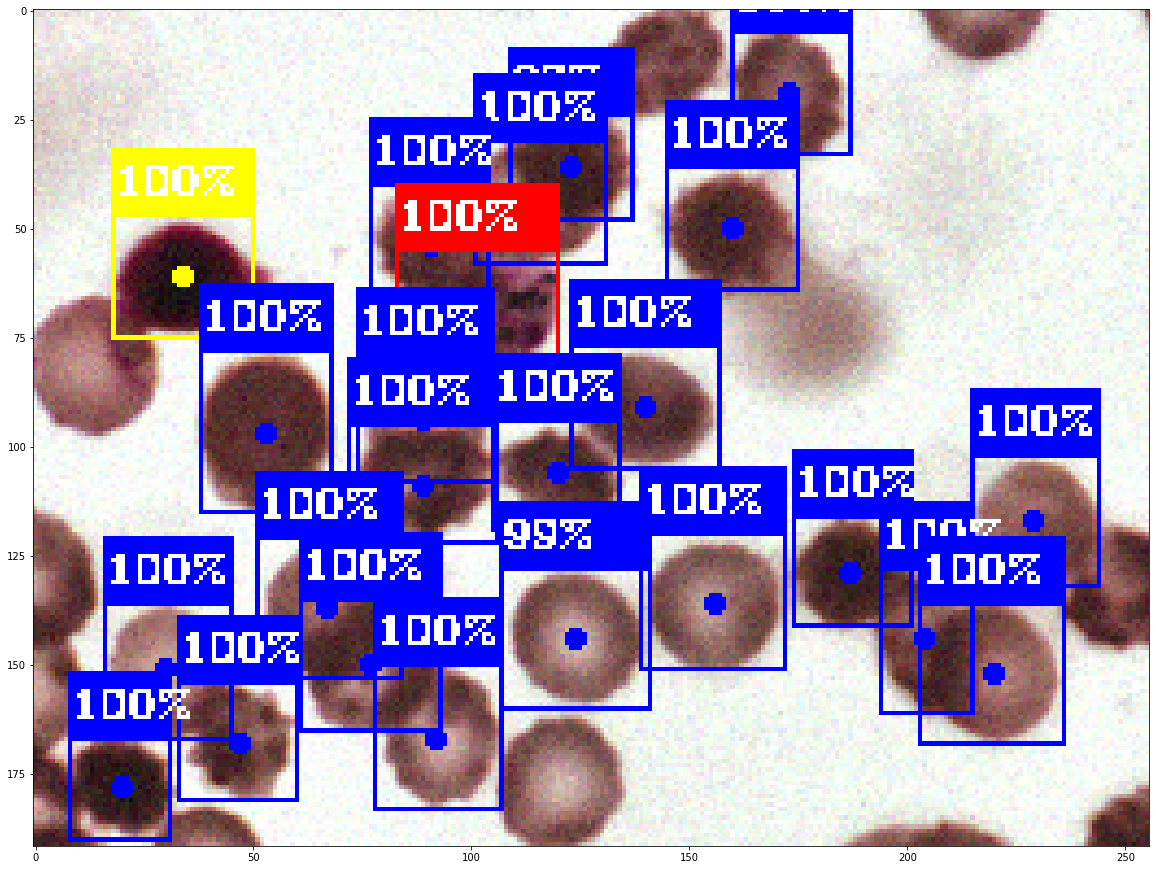

In [0]:
plt.figure(figsize=(20,20))
plt.imshow(images[i])
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


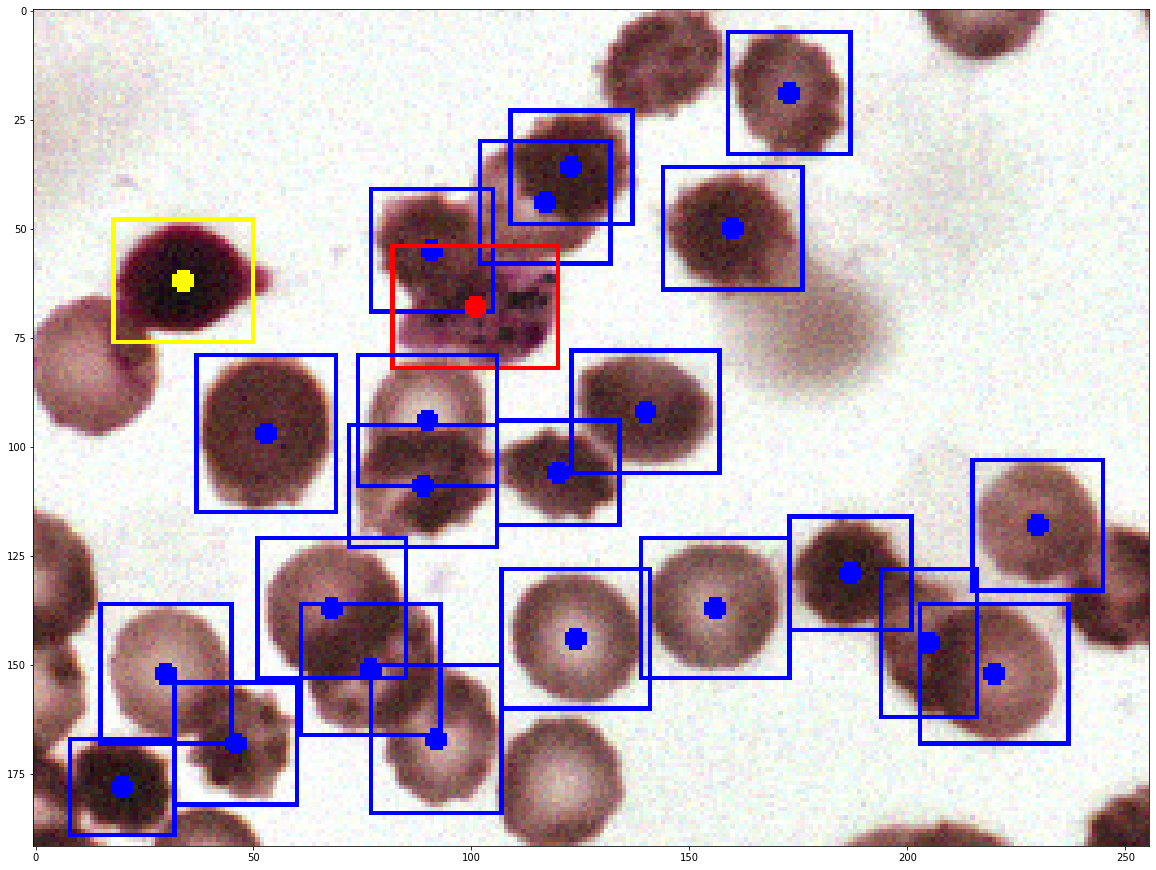

In [0]:
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


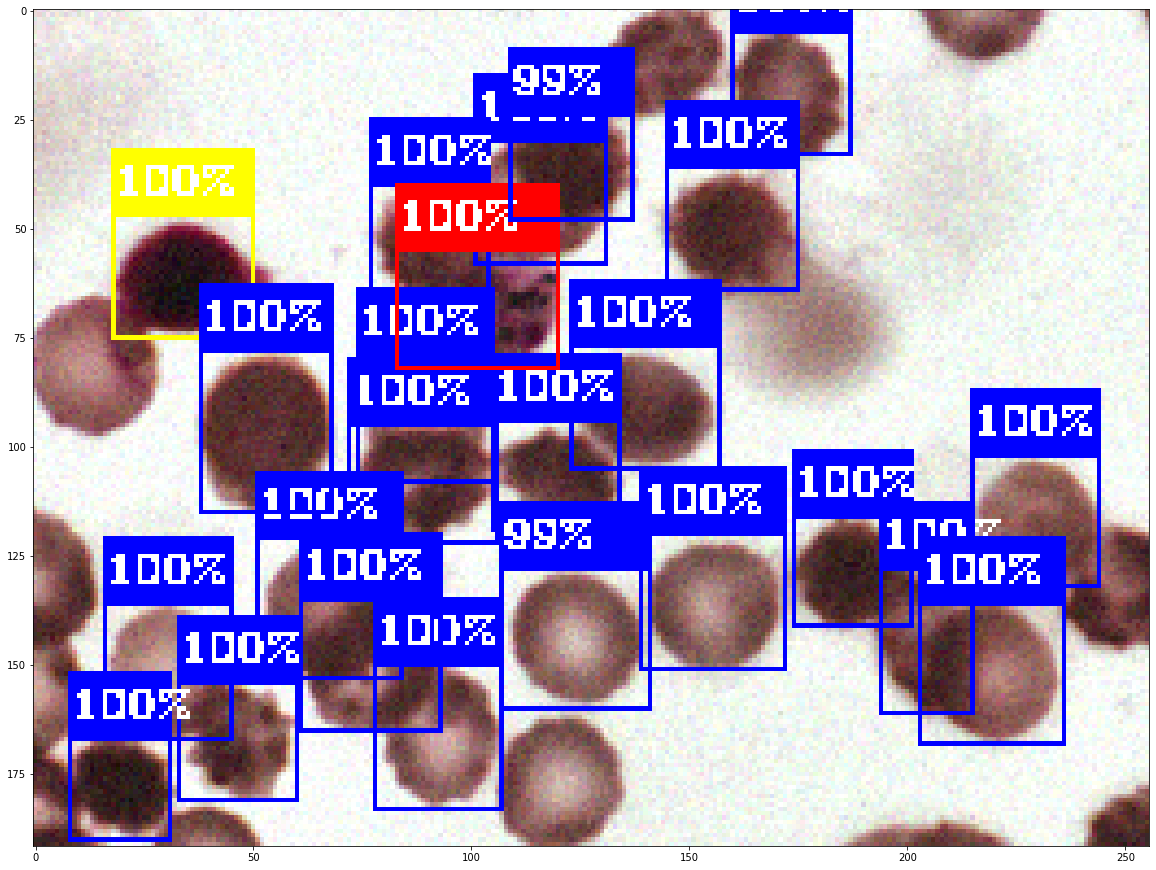

In [0]:
plt.figure(figsize=(20,20))
plt.imshow(img2)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


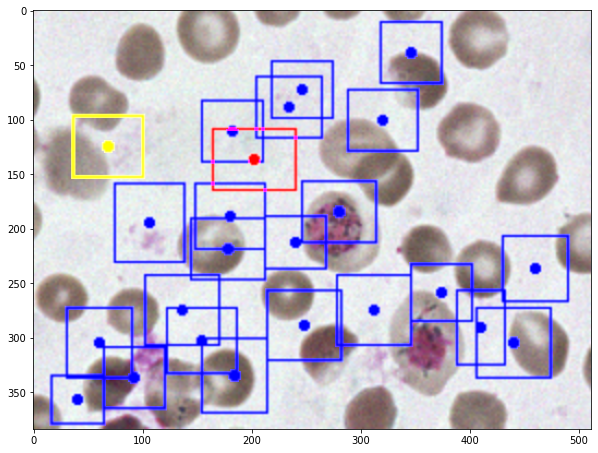

In [0]:
import cv2
import numpy as np
import common
import config




image_=common.prepare_image(images[2], labels[i], False)


plt.figure(figsize=(10,10))
plt.imshow(cv2.resize(image_, (2*config.largeur, 2*config.hauteur)))
plt.show()


In [0]:
plt.close()